In [1]:
# Installation des dépendances essentielles
!pip install tensorflow==2.17.0  
!pip install keras==3.7.0        
!pip install pandas==2.2.2       
!pip install scikit-learn==1.5.0 
!pip install matplotlib==3.8.0   
!pip install opencv-python      

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 2.7 MB/s eta 0:00:000:00:0100:01
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 16.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 85.0 MB/s eta 0:00:00:00:01:01
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.3
    Uninstalling pandas-2.2.3:
      Successfully uninstalled pandas-2.2.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires notebook==6.5.5, but you have notebook 6.5.4 which is incom

In [2]:
# Import des bibliothèques essentielles
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# OpenCV pour manipulation d'images
import cv2

# Librairies Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# Vérification du GPU
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

# Définition du répertoire du dataset
data_dir = "/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train"

print("Modules chargés avec succès")


Num GPUs Available: 2
Modules chargés avec succès


In [3]:
# Fonction pour charger le dataset ASL Alphabet
def recupDataset(data_dir):
    filepaths = []
    labels = []
    
    # Parcours des dossiers (chaque dossier = une lettre)
    for fold in os.listdir(data_dir):
        foldpath = os.path.join(data_dir, fold)
        
        # Vérification que c'est bien un dossier
        if os.path.isdir(foldpath):
            for file in os.listdir(foldpath):
                fpath = os.path.join(foldpath, file)
                filepaths.append(fpath)
                labels.append(fold)  # Nom du dossier = label
    
    # Création d'un DataFrame
    dataset = pd.DataFrame({'filepaths': filepaths, 'labels': labels})
    print(f"Total images chargées : {len(dataset)}")
    print(f"Classes détectées : {dataset['labels'].nunique()}")
    
    return dataset

# Charger le dataset
dataset = recupDataset(data_dir)

# Affichage des 5 premières images chargées
dataset.head()

Total images chargées : 87000
Classes détectées : 29


,filepaths,labels
0,/kaggle/input/asl-alphabet/asl_alphabet_train/...,N
1,/kaggle/input/asl-alphabet/asl_alphabet_train/...,N
2,/kaggle/input/asl-alphabet/asl_alphabet_train/...,N
3,/kaggle/input/asl-alphabet/asl_alphabet_train/...,N
4,/kaggle/input/asl-alphabet/asl_alphabet_train/...,N


In [4]:
from sklearn.model_selection import train_test_split

# Charger le dataset
dataset = recupDataset(data_dir)

# Séparation en train (80%) et test (20%)
train_df, test_df = train_test_split(dataset, test_size=0.08, stratify=dataset['labels'], random_state=42)

# Séparation de train en train (80%) et validation (12%)
train_df, valid_df = train_test_split(train_df, test_size=0.12/0.92, stratify=train_df['labels'], random_state=42)

# Vérification des dimensions
print(f"Total images chargées : {len(dataset)}")
print(f"Classes détectées : {dataset['labels'].nunique()}")
print(f"Train set : {len(train_df)} images")
print(f"Validation set : {len(valid_df)} images")
print(f"Test set : {len(test_df)} images")

# Affichage des premières lignes du train set
train_df.head()


Total images chargées : 87000
Classes détectées : 29
Total images chargées : 87000
Classes détectées : 29
Train set : 69600 images
Validation set : 10440 images
Test set : 6960 images


,filepaths,labels
6294,/kaggle/input/asl-alphabet/asl_alphabet_train/...,space
46139,/kaggle/input/asl-alphabet/asl_alphabet_train/...,S
66502,/kaggle/input/asl-alphabet/asl_alphabet_train/...,C
13362,/kaggle/input/asl-alphabet/asl_alphabet_train/...,I
41263,/kaggle/input/asl-alphabet/asl_alphabet_train/...,Q


In [5]:
# Paramètres
batch_size = 64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Détermination automatique du batch size optimal pour le test
ts_length = len(test_df)
test_batch_size = min(batch_size, len(test_df)) 
test_steps = ts_length // test_batch_size

# Générateurs d'images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  
    brightness_range=[0.5, 1.5],  
    zoom_range=0.3,
    horizontal_flip=False,  # On empêche de retourner l’image, car important en langue des signes
)

test_datagen = ImageDataGenerator(rescale=1./255)  # Normalisation seulement pour validation et test

# Création des générateurs
train_generator = train_datagen.flow_from_dataframe(
    train_df, x_col='filepaths', y_col='labels', target_size=img_size,
    class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size
)

valid_generator = test_datagen.flow_from_dataframe(
    valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
    class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size
)


test_generator = test_datagen.flow_from_dataframe(
    test_df, x_col='filepaths', y_col='labels', target_size=img_size,
    class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size
)

Found 69600 validated image filenames belonging to 29 classes.
Found 10440 validated image filenames belonging to 29 classes.
Found 6960 validated image filenames belonging to 29 classes.


In [6]:
import json

# Récupération des classes dans l’ordre
class_indices = train_generator.class_indices
inv_class_indices = {v: k for k, v in class_indices.items()}  # index -> label

# Sauvegarde dans un fichier JSON
with open('/kaggle/working/classes.json', 'w') as f:
    json.dump(inv_class_indices, f)

print("Ordre des classes sauvegardé.")


Ordre des classes sauvegardé.


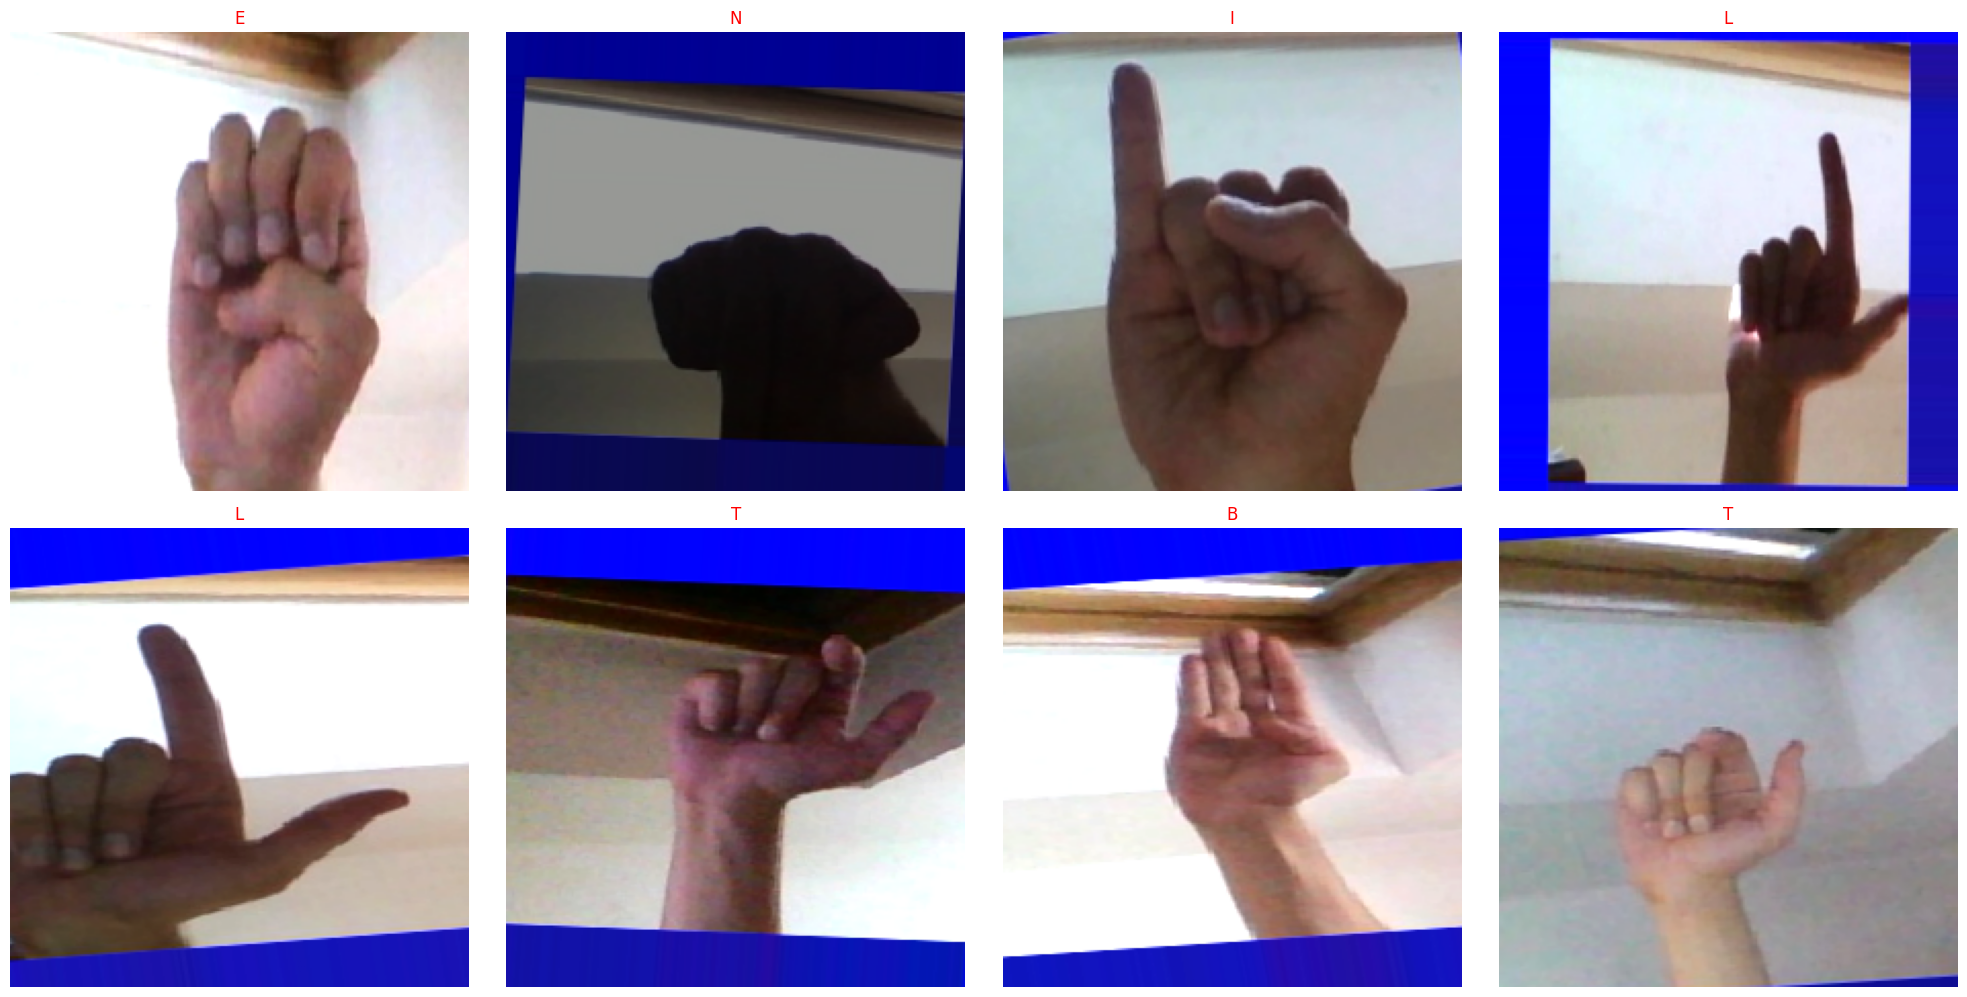

In [7]:
# Affichage d'échantillons du dataset d'entraînement
g_dict = train_generator.class_indices  # Dictionnaire {'classe': index}
classes = list(g_dict.keys())           # Liste des classes

# Extraction d'un batch d'images
images, labels = next(train_generator)

# Affichage
plt.figure(figsize=(20, 20))
for i in range(8):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i])  # Image déjà normalisée
    index = np.argmax(labels[i])  # Obtenir l'index de la classe
    class_name = classes[index]  # Obtenir le nom de la classe
    plt.title(class_name, color='red', fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [8]:
# Définition de l'architecture du modèle CNN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# === PARAMÈTRES GÉNÉRAUX ===
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
num_classes = 29

# === CALLBACKS ===
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=1)

# === BACKBONE ===
EffNetB0 = EfficientNetB0(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
EffNetB0.trainable = False  # Phase 1 : gelé

# === MODÈLE ===
model = Sequential([
    EffNetB0,
    BatchNormalization(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 1280)                │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 29)                  │           3,741 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,419,264 (16.86 MB)

 Trainable params: 367,133 (1.40 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [9]:
# === Compilation Phase 1 ===
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# === Entraînement Phase 1 ===
history_phase1 = model.fit(
    train_generator,
    epochs=5,
    validation_data=valid_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 1503s 1s/step - accuracy: 0.0347 - loss: 4.0506 - val_accuracy: 0.0348 - val_loss: 3.9089 - learning_rate: 1.0000e-04
Epoch 2/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 1006s 925ms/step - accuracy: 0.0350 - loss: 3.9058 - val_accuracy: 0.0345 - val_loss: 3.8401 - learning_rate: 1.0000e-04
Epoch 3/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 1025s 942ms/step - accuracy: 0.0358 - loss: 3.8264 - val_accuracy: 0.0336 - val_loss: 3.7583 - learning_rate: 1.0000e-04
Epoch 4/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 998s 917ms/step - accuracy: 0.0331 - loss: 3.7400 - val_accuracy: 0.0330 - val_loss: 3.6698 - learning_rate: 1.0000e-04
Epoch 5/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 998s 917ms/step - accuracy: 0.0344 - loss: 3.6502 - val_accuracy: 0.0348 - val_loss: 3.5830 - learning_rate: 1.0000e-04


In [10]:
# === Dégel du backbone ===
EffNetB0.trainable = True

# === Compilation Phase 2 ===
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# === Entraînement Phase 2 ===
history_phase2 = model.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 1164s 999ms/step - accuracy: 0.0500 - loss: 3.5681 - val_accuracy: 0.0571 - val_loss: 3.5327 - learning_rate: 1.0000e-05
Epoch 2/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 889ms/step - accuracy: 0.2767 - loss: 3.0152
Epoch 2: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 994s 913ms/step - accuracy: 0.2768 - loss: 3.0148 - val_accuracy: 0.0476 - val_loss: 3.7183 - learning_rate: 1.0000e-05
Epoch 3/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 975s 896ms/step - accuracy: 0.6920 - loss: 1.4164 - val_accuracy: 0.9386 - val_loss: 0.6785 - learning_rate: 5.0000e-06
Epoch 4/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 967s 888ms/step - accuracy: 0.8419 - loss: 0.8567 - val_accuracy: 0.9207 - val_loss: 0.5732 - learning_rate: 5.0000e-06
Epoch 5/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 968s 889ms/step - accuracy: 0.9116 - loss: 0.5879 - val_accuracy: 0.9849 - val_loss: 0.2957 - learning_rate: 5.0000e-06
Epoch 6/10
1088/1088 ━━━━━━━━━━━━━

In [11]:
# Sauvegarde du modèle/
model.save("/kaggle/working/asl_model.h5")
print("Modèle entraîné et sauvegardé avec succès")

Modèle entraîné et sauvegardé avec succès


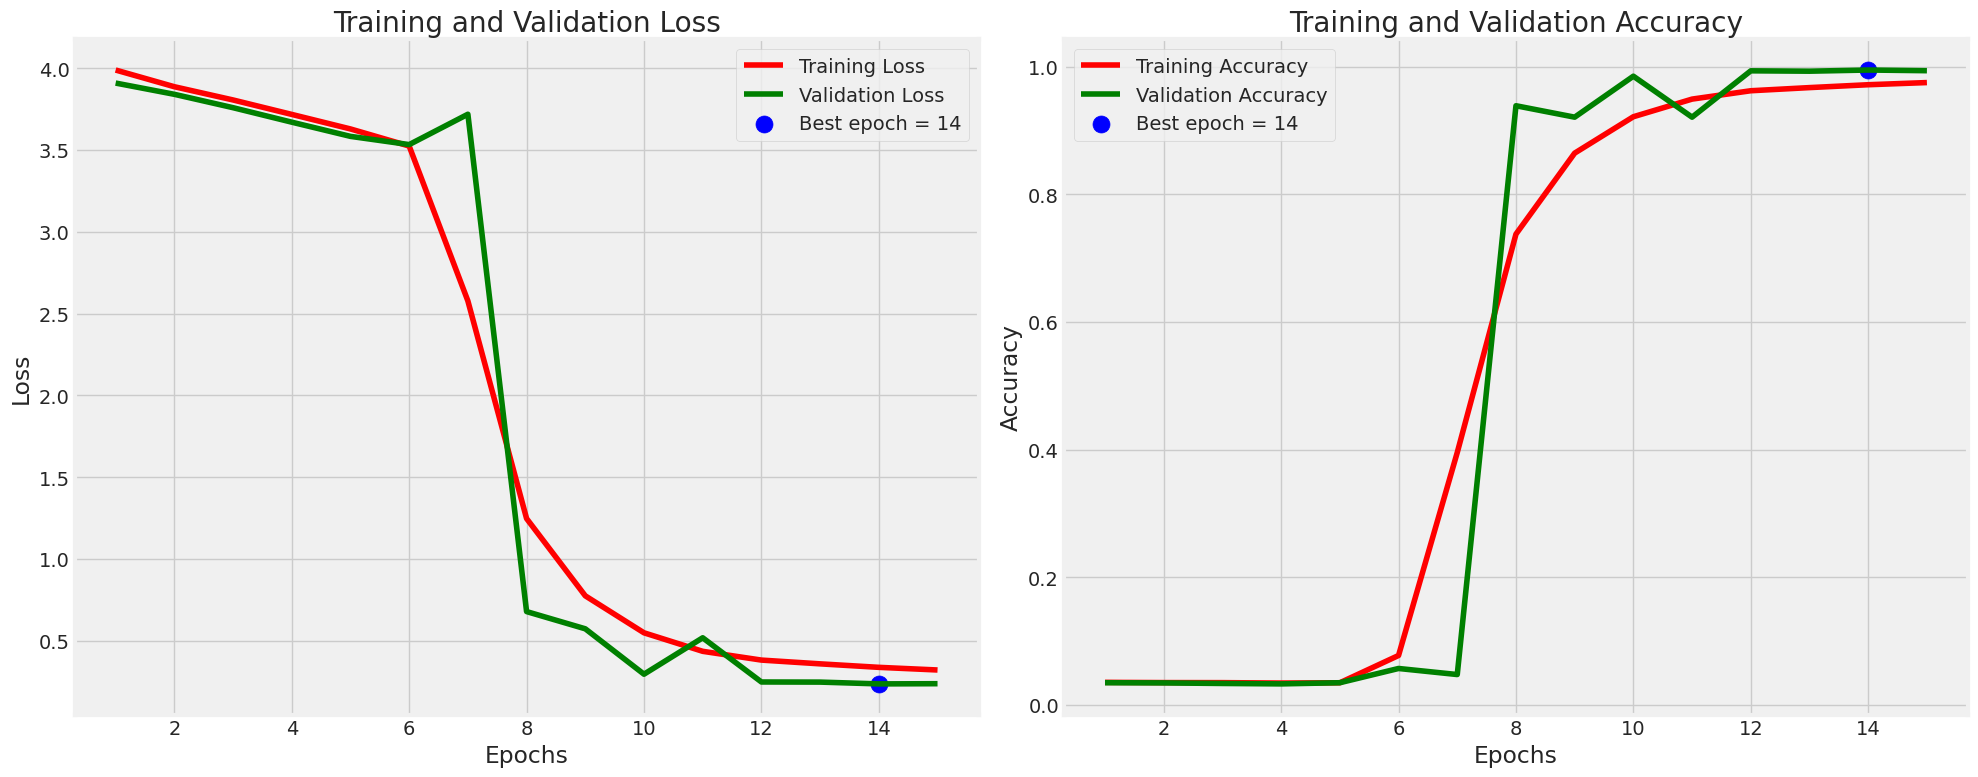

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Fusion des historiques phase 1 et phase 2
def combine_histories(h1, h2):
    history = {}
    for key in h1.history:
        history[key] = h1.history[key] + h2.history[key]
    return history

full_history = combine_histories(history_phase1, history_phase2)

# Récupération des métriques combinées
tr_acc = full_history['accuracy']
tr_loss = full_history['loss']
val_acc = full_history['val_accuracy']
val_loss = full_history['val_loss']

# Meilleures époques
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {index_loss + 1}'
acc_label = f'Best epoch = {index_acc + 1}'

# Plot des performances du modèle
plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

# --- Courbe de perte ---
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training Loss')
plt.plot(Epochs, val_loss, 'g', label='Validation Loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# --- Courbe de précision ---
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [13]:
# Évaluation du modèle sur les sets d'entraînement, validation et test
train_score = model.evaluate(train_generator, verbose=1)
valid_score = model.evaluate(valid_generator, verbose=1)
test_score = model.evaluate(test_generator, verbose=1)

# Affichage des performances
print("\n**Performance finale du modèle**")
print(f"{'Set':<15}{'Loss':<15}{'Accuracy'}")
print("-" * 40)
print(f"{'Train':<15}{train_score[0]:<15.4f}{train_score[1]*100:.2f}%")
print(f"{'Validation':<15}{valid_score[0]:<15.4f}{valid_score[1]*100:.2f}%")
print(f"{'Test':<15}{test_score[0]:<15.4f}{test_score[1]*100:.2f}%")


1088/1088 ━━━━━━━━━━━━━━━━━━━━ 930s 855ms/step - accuracy: 0.9937 - loss: 0.2384
164/164 ━━━━━━━━━━━━━━━━━━━━ 29s 175ms/step - accuracy: 0.9943 - loss: 0.2385
109/109 ━━━━━━━━━━━━━━━━━━━━ 85s 783ms/step - accuracy: 0.9960 - loss: 0.2319

**Performance finale du modèle**
Set            Loss           Accuracy
----------------------------------------
Train          0.2392         99.34%
Validation     0.2365         99.45%
Test           0.2320         99.60%


In [14]:
# Prédictions sur le jeu de test
preds = model.predict(test_generator)
y_pred = np.argmax(preds, axis=1)  # Classes prédites
y_true = test_generator.classes  # Classes réelles

# Vérification
print(f"Nombre total d'images testées : {len(y_true)}")
print(f"Nombre total de prédictions faites : {len(y_pred)}")


109/109 ━━━━━━━━━━━━━━━━━━━━ 32s 235ms/step
Nombre total d'images testées : 6960
Nombre total de prédictions faites : 6960


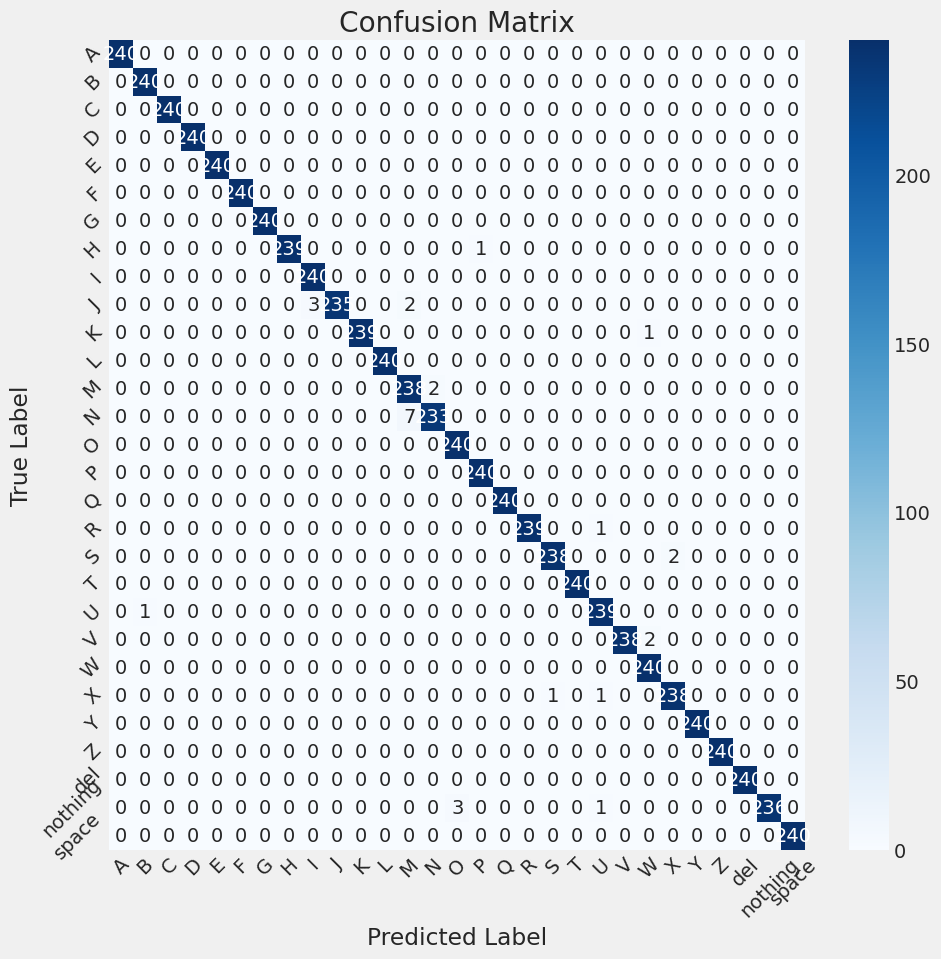


**Classification Report**
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       240
           B       1.00      1.00      1.00       240
           C       1.00      1.00      1.00       240
           D       1.00      1.00      1.00       240
           E       1.00      1.00      1.00       240
           F       1.00      1.00      1.00       240
           G       1.00      1.00      1.00       240
           H       1.00      1.00      1.00       240
           I       0.99      1.00      0.99       240
           J       1.00      0.98      0.99       240
           K       1.00      1.00      1.00       240
           L       1.00      1.00      1.00       240
           M       0.96      0.99      0.98       240
           N       0.99      0.97      0.98       240
           O       0.99      1.00      0.99       240
           P       1.00      1.00      1.00       240
           Q       1.00      1.00      1.00       240


In [15]:
# Dictionnaire des classes
g_dict = test_generator.class_indices
classes = list(g_dict.keys())

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)

# Affichage amélioré avec seaborn
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

# Rapport de classification
print("\n**Classification Report**")
print(classification_report(y_true, y_pred, target_names=classes))

In [16]:
# Affichage du rapport de classification
print("\n**Classification Report**")
print("-" * 50)
print(classification_report(y_true, y_pred, target_names=classes))
print("-" * 50)


**Classification Report**
--------------------------------------------------
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       240
           B       1.00      1.00      1.00       240
           C       1.00      1.00      1.00       240
           D       1.00      1.00      1.00       240
           E       1.00      1.00      1.00       240
           F       1.00      1.00      1.00       240
           G       1.00      1.00      1.00       240
           H       1.00      1.00      1.00       240
           I       0.99      1.00      0.99       240
           J       1.00      0.98      0.99       240
           K       1.00      1.00      1.00       240
           L       1.00      1.00      1.00       240
           M       0.96      0.99      0.98       240
           N       0.99      0.97      0.98       240
           O       0.99      1.00      0.99       240
           P       1.00      1.00      1.00       240
   

In [17]:
# Création du dossier de sauvegarde (si non existant)
save_dir = "/kaggle/working/saved_model"
os.makedirs(save_dir, exist_ok=True)

# Sauvegarde complète du modèle
model.save(os.path.join(save_dir, "ASL_CNN_model.h5"))

# Sauvegarde uniquement des poids
model.save_weights(os.path.join(save_dir, "ASL_CNN_model_weights.weights.h5"))

print("Modèle et poids sauvegardés avec succès dans", save_dir)

Modèle et poids sauvegardés avec succès dans /kaggle/working/saved_model


In [18]:
from tensorflow.keras.utils import load_img, img_to_array

# Fonction pour charger une image et la préparer pour la prédiction
def load_image(img_path, show=False):
    img = load_img(img_path, target_size=(224, 224))  # Charger l'image
    img_tensor = img_to_array(img)  # Convertir en tableau NumPy
    img_tensor = np.expand_dims(img_tensor, axis=0)  # Ajouter une dimension pour batch
    img_tensor /= 255.  # Normalisation des pixels

    if show:
        plt.imshow(img_tensor[0])
        plt.axis('off')
        plt.show()

    return img_tensor

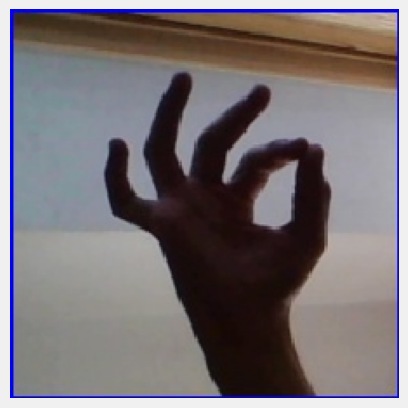

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

**Résultat de la Prédiction**
Classe prédite : F (Index: 5)
Probabilités : [[6.23348697e-08 1.58085641e-06 2.43986233e-05 5.49339234e-07
  5.59905347e-05 9.99848485e-01 5.13213763e-07 2.16007081e-07
  7.54909070e-06 1.64627409e-07 5.37871898e-08 8.49603168e-07
  3.41869324e-08 1.66558784e-05 8.36110303e-06 1.89048615e-06
  6.02679256e-06 2.23278505e-07 1.12825006e-07 4.46856075e-06
  5.02541980e-07 1.92708242e-07 1.22665369e-05 1.55621464e-07
  1.09420107e-07 7.67706661e-06 8.24757308e-07 8.59012061e-08
  1.43390238e-07]]


In [22]:
# Charger une image de test
img_path = "/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/F_test.jpg"  # Remplace par une image valide
new_image = load_image(img_path, show=True)

# Faire une prédiction
pred = model.predict(new_image)

# Trouver la classe prédite
predicted_index = np.argmax(pred)  # Index de la classe avec la plus haute probabilité
predicted_label = classes[predicted_index]  # Nom de la classe correspondante

# Affichage du résultat
print("\n**Résultat de la Prédiction**")
print(f"Classe prédite : {predicted_label} (Index: {predicted_index})")
print(f"Probabilités : {pred}")